# Linear Combination Fitting — µ-XANES Spectra

Fit each cluster centroid and individual µ-XANES spectrum as a linear combination
of mineral reference spectra. Also explores sub-cluster structure within specific clusters.

**Requires:** Run `01_pca_clustering.ipynb` first.

**Inputs:**
- `flattened-spectra/*.csv` — sample spectra
- `FeK-standards/fluorescence/flattened/*.csv` — reference mineral spectra

**Outputs:**
- `pca_results/lcf_centroids.png` — LCF fits of cluster centroids
- `pca_results/lcf_individual.csv` — per-spectrum LCF results
- `pca_results/subcluster_*.png` — sub-cluster analysis plots

## Imports and configuration

In [1]:
"""
XAS Spectra PCA + Clustering Pipeline
======================================
Reads pre-normalized XANES/EXAFS spectra, performs PCA to identify
the number of distinct spectral components, then clusters spectra
in PC-score space to group similar grains.

Assumes spectra are already normalized/flattened (e.g., via Athena or Larch).
Uses the flattened (post-edge-corrected) XANES by default to avoid
post-edge slope artifacts in PCA.

Requirements:
    pip install xraylarch scikit-learn scipy matplotlib numpy pandas

Usage:
    1. Update the CONFIGURATION section below with your paths and parameters.
    2. Run: python xas_pca_clustering.py
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from pathlib import Path
import pandas as pd

# Larch imports
from larch import Group
from larch.math import pca_train

In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

# Directory containing your normalized spectra files
SPECTRA_DIR = Path("./flattened-spectra")

# Energy range to use for PCA (eV, relative to E0 or absolute)
# Set to None to use the full overlapping range
E_MIN = 7100  # e.g., -20 (relative to E0) or 7100 (absolute)
E_MAX = 7180  # e.g., 80 (relative to E0) or 7200 (absolute)
ENERGY_IS_RELATIVE = False  # True if E_MIN/E_MAX are relative to E0

# PCA region: 'xanes' uses normalized mu(E), 'exafs' uses chi(k)
PCA_REGION = "xanes"

# Common energy/k grid spacing for interpolation
E_STEP = 0.2  # eV step for XANES

# Max number of clusters to evaluate
MAX_CLUSTERS = 15

# Set to None to use silhouette-optimal k, or an integer to override
FORCE_K = 5

# Number of PCA components to use for clustering and target transformation.
# Set to None to use the IND minimum (automatic), or override with an integer
# if IND gives an unreasonable result (common with noisy microprobe data).
N_COMPONENTS = 5

# Reference spectra for target transformation (optional)
# List of file paths to reference spectra
REFERENCE_DIR = Path("./FeK-standards/fluorescence/flattened")
REFERENCE_FILES = ["2L-Fhy on sand.csv",
                    "2L-Fhy.csv",
                    "6L-Fhy.csv",
                    "Augite.csv",
                    "Biotite.csv",
                    "FeS.csv",
                    "Ferrosmectite.csv",
                    "Goethite on sand.csv",
                    "Goethite.csv",
                    "Green Rust - Carbonate.csv",
                    "Green Rust - Chloride.csv",
                    "Green Rust - Sulfate.csv",
                    "Hematite on sand.csv",
                    "Hematite.csv",
                    "Hornblende.csv",
                    "Ilmenite.csv",
                    "Jarosite.csv",
                    "Lepidocrocite.csv",
                    "Mackinawite (aged).csv",
                    "Mackinawite.csv",
                    "Maghemite.csv",
                    "Nontronite.csv",
                    "Pyrite.csv",
                    "Pyrrhotite.csv",
                    "Schwertmannite.csv",
                    "Siderite-n.csv",
                    "Siderite-s.csv",
                    "Vivianite.csv"] 
                    
REFERENCE_PATHS = [REFERENCE_DIR / f for f in REFERENCE_FILES]
# Output directory

# Bulk directory
BULK_DIR = Path("./bulk")
BULK_PATTERN = '*.csv'

OUTPUT_DIR = Path("./pca_results")

## Data loading and PCA

Re-run the pipeline up through clustering to get the required variables in memory.

In [3]:
def load_ascii_spectra(spectra_dir, pattern="*.csv"):
    """
    Load pre-normalized/flattened spectra from individual CSV files.
    Expected format: comment lines starting with #, then two columns
    (energy, flat) comma-separated.
    """
    groups = []
    files = sorted(Path(spectra_dir).glob(pattern))
    for f in files:
        try:
            data = np.loadtxt(str(f), delimiter=",", comments="#")
            g = Group(
                energy=data[:, 0],
                flat=data[:, 1],
                filename=f.stem,
                _name=f.stem,
            )
            groups.append(g)
        except Exception as e:
            print(f"  Skipping {f.name}: {e}")
    print(f"Loaded {len(groups)} spectra from {spectra_dir}")
    return groups

In [4]:
def build_xanes_matrix(groups, e_min=None, e_max=None):
    """
    Interpolate normalized XANES spectra onto a common energy grid.
    Returns: energy_grid (1D), matrix (n_spectra x n_energy), names list
    """
    # Find the common energy range
    all_emin = max(g.energy.min() for g in groups)
    all_emax = min(g.energy.max() for g in groups)

    if e_min is not None:
        if ENERGY_IS_RELATIVE:
            # Use median E0 as reference
            e0_median = np.median([g.e0 for g in groups])
            all_emin = max(all_emin, e0_median + e_min)
        else:
            all_emin = max(all_emin, e_min)

    if e_max is not None:
        if ENERGY_IS_RELATIVE:
            e0_median = np.median([g.e0 for g in groups])
            all_emax = min(all_emax, e0_median + e_max)
        else:
            all_emax = min(all_emax, e_max)

    energy_grid = np.arange(all_emin, all_emax, E_STEP)
    matrix = np.zeros((len(groups), len(energy_grid)))
    names = []

    for i, g in enumerate(groups):
        matrix[i, :] = np.interp(energy_grid, g.energy, g.flat)
        names.append(g._name)

    print(f"Spectral matrix: {matrix.shape[0]} spectra × {matrix.shape[1]} energy points")
    print(f"Energy range: {energy_grid[0]:.1f} – {energy_grid[-1]:.1f} eV")
    return energy_grid, matrix, names

In [5]:
# ============================================================
# QUALITY SCREENING
# ============================================================

def screen_spectra(matrix, names, sigma_threshold=3.0):
    """
    Remove outlier spectra based on their distance from the mean spectrum.
    Returns filtered matrix and names.
    """
    mean_spec = matrix.mean(axis=0)
    distances = np.sqrt(np.sum((matrix - mean_spec) ** 2, axis=1))
    threshold = distances.mean() + sigma_threshold * distances.std()

    mask = distances < threshold
    n_removed = (~mask).sum()
    if n_removed > 0:
        print(f"Quality screen: removed {n_removed} spectra beyond {sigma_threshold}σ")
        removed_names = [names[i] for i in range(len(names)) if not mask[i]]
        for rn in removed_names:
            print(f"    Removed: {rn}")
    else:
        print("Quality screen: all spectra passed")

    filtered_names = [names[i] for i in range(len(names)) if mask[i]]
    return matrix[mask], filtered_names, mask

In [6]:
# ============================================================
# PCA
# ============================================================

def run_pca(x_grid, matrix, names):
    """
    Run PCA using Larch's pca_train.
    Returns the PCA result group.
    """
    # Build Larch groups for pca_train
    groups_for_pca = []
    for i in range(matrix.shape[0]):
        g = Group()
        if PCA_REGION == "xanes":
            g.energy = x_grid
            g.flat = matrix[i, :]
        else:
            g.k = x_grid
            g.chi = matrix[i, :] / (x_grid ** K_WEIGHT)  # undo k-weight
        g._name = names[i]
        groups_for_pca.append(g)

    if PCA_REGION == "xanes":
        pca_result = pca_train(groups_for_pca, arrayname="flat")
    else:
        pca_result = pca_train(groups_for_pca, arrayname="chi")

    return pca_result


def plot_pca_diagnostics(pca_result, output_dir):
    """Plot scree plot, IND, and component spectra."""
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

    n_show = min(20, len(pca_result.variances))

    # --- Scree plot ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(range(1, n_show + 1), pca_result.variances[:n_show], "ko-")
    ax1.set_xlabel("Component number")
    ax1.set_ylabel("Eigenvalue (variance)")
    ax1.set_title("Scree Plot")
    ax1.set_xticks(range(1, n_show + 1))
    ax1.grid(True, alpha=0.3)

    # --- IND function ---
    ax2 = fig.add_subplot(gs[0, 1])
    ind = pca_result.ind
    ax2.semilogy(range(1, len(ind) + 1), ind, "rs-")
    ind_min = np.argmin(ind) + 1
    ax2.axvline(ind_min, color="blue", linestyle="--", label=f"IND min = {ind_min}")
    ax2.set_xlabel("Component number")
    ax2.set_ylabel("IND")
    ax2.set_title(f"Indicator Function (minimum at {ind_min} components)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # --- First few component spectra ---
    ax3 = fig.add_subplot(gs[1, 0])
    n_comp_show = min(5, ind_min + 2)
    for i in range(n_comp_show):
        offset = i * 0.5
        ax3.plot(pca_result.components[i] + offset, label=f"PC{i+1}")
    ax3.set_xlabel("Point index")
    ax3.set_ylabel("Component loading (offset)")
    ax3.set_title("Principal Component Spectra")
    ax3.legend(fontsize=8)

    # --- Cumulative variance ---
    ax4 = fig.add_subplot(gs[1, 1])
    cumvar = np.cumsum(pca_result.variances) / np.sum(pca_result.variances) * 100
    ax4.plot(range(1, n_show + 1), cumvar[:n_show], "go-")
    ax4.axhline(95, color="red", linestyle="--", alpha=0.5, label="95%")
    ax4.axhline(99, color="red", linestyle=":", alpha=0.5, label="99%")
    ax4.set_xlabel("Number of components")
    ax4.set_ylabel("Cumulative variance (%)")
    ax4.set_title("Cumulative Variance Explained")
    ax4.legend()
    ax4.set_xticks(range(1, n_show + 1))
    ax4.grid(True, alpha=0.3)

    plt.savefig(output_dir / "pca_diagnostics.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: pca_diagnostics.png")
    return ind_min

In [7]:
# ============================================================
# CLUSTERING
# ============================================================

def evaluate_kmeans(scores, max_k):
    """Evaluate k-means for different numbers of clusters."""
    results = {"k": [], "inertia": [], "silhouette": []}
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(scores)
        results["k"].append(k)
        results["inertia"].append(km.inertia_)
        results["silhouette"].append(silhouette_score(scores, labels))
    return results


def run_clustering(scores, names, n_components, output_dir):
    """
    Run k-means and hierarchical clustering on PCA scores.
    Produces diagnostic plots and returns cluster assignments.
    """
    max_k = min(MAX_CLUSTERS, len(names) - 1)

    # --- Evaluate k-means ---
    km_results = evaluate_kmeans(scores, max_k)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Elbow plot
    axes[0].plot(km_results["k"], km_results["inertia"], "ko-")
    axes[0].set_xlabel("Number of clusters (k)")
    axes[0].set_ylabel("Inertia (within-cluster SS)")
    axes[0].set_title("K-Means Elbow Plot")
    axes[0].grid(True, alpha=0.3)

    # Silhouette plot
    axes[1].plot(km_results["k"], km_results["silhouette"], "bs-")
    best_k = km_results["k"][np.argmax(km_results["silhouette"])]
    axes[1].axvline(best_k, color="red", linestyle="--",
                    label=f"Best k = {best_k}")
    axes[1].set_xlabel("Number of clusters (k)")
    axes[1].set_ylabel("Silhouette score")
    axes[1].set_title("Silhouette Analysis")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(output_dir / "kmeans_evaluation.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: kmeans_evaluation.png")
    print(f"Optimal k by silhouette: {best_k}")

    # --- Hierarchical clustering dendrogram ---
    linkage_matrix = linkage(pdist(scores, metric="euclidean"), method="ward")

    fig, ax = plt.subplots(figsize=(16, 8))
    dendrogram(
        linkage_matrix,
        labels=names,
        leaf_rotation=90,
        leaf_font_size=6,
        ax=ax,
    )
    ax.set_title("Hierarchical Clustering Dendrogram (Ward linkage)")
    ax.set_ylabel("Distance")
    plt.tight_layout()
    plt.savefig(output_dir / "dendrogram.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: dendrogram.png")

    # --- Score scatter plots with cluster assignments ---
    km_best = KMeans(n_clusters=best_k, n_init=20, random_state=42)
    labels = km_best.fit_predict(scores)

    n_pairs = min(3, n_components - 1)
    fig, axes = plt.subplots(1, n_pairs, figsize=(6 * n_pairs, 5))
    if n_pairs == 1:
        axes = [axes]

    pc_pairs = [(0, 1), (0, 2), (1, 2)][:n_pairs]
    for ax, (i, j) in zip(axes, pc_pairs):
        scatter = ax.scatter(scores[:, i], scores[:, j], c=labels,
                             cmap="tab10", s=40, edgecolors="k", linewidths=0.5)
        ax.set_xlabel(f"PC{i+1} score")
        ax.set_ylabel(f"PC{j+1} score")
        ax.set_title(f"PC{i+1} vs PC{j+1}")
        ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[-1], label="Cluster")
    plt.tight_layout()
    plt.savefig(output_dir / "score_scatter.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: score_scatter.png")

    return labels, best_k, km_best

In [8]:
# ============================================================
# CLUSTER INSPECTION
# ============================================================

def plot_cluster_spectra(x_grid, matrix, names, labels, n_clusters, output_dir):
    """Plot all spectra in each cluster, plus cluster centroids."""
    xlabel = "Energy (eV)" if PCA_REGION == "xanes" else f"k (Å⁻¹)"

    # Individual cluster plots
    fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5),
                             sharey=True)
    if n_clusters == 1:
        axes = [axes]

    centroids = []
    for ci in range(n_clusters):
        mask = labels == ci
        cluster_spectra = matrix[mask]
        centroid = cluster_spectra.mean(axis=0)
        centroids.append(centroid)
        cluster_names = [names[i] for i in range(len(names)) if mask[i]]

        ax = axes[ci]
        for spec in cluster_spectra:
            ax.plot(x_grid, spec, alpha=0.3, color=f"C{ci}")
        ax.plot(x_grid, centroid, "k-", linewidth=2, label="Centroid")
        ax.set_xlabel(xlabel)
        ax.set_title(f"Cluster {ci+1} (n={mask.sum()})")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Flattened μ(E)" if PCA_REGION == "xanes" else f"k^{K_WEIGHT}·χ(k)")
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_spectra.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: cluster_spectra.png")

    # Overlay of all centroids
    fig, ax = plt.subplots(figsize=(8, 6))
    for ci, centroid in enumerate(centroids):
        ax.plot(x_grid, centroid, label=f"Cluster {ci+1}", linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Flattened μ(E)" if PCA_REGION == "xanes" else f"k^{K_WEIGHT}·χ(k)")
    ax.set_title("Cluster Centroids Comparison")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_centroids.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: cluster_centroids.png")

    return np.array(centroids)

In [9]:
# ============================================================
# HELPER FUNCTIONS FOR INTERACTIVE EXPLORATION
# ============================================================

def override_clusters(scores, k):
    """Re-cluster with a specific k."""
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(scores)
    print(f"Clustered into k={k}:")
    for i in range(k):
        print(f"  Cluster {i+1}: {(labels==i).sum()} spectra")
    return labels, k

def plot_score_scatter(scores, labels, n_components, best_k, output_dir=None, suffix=""):
    """Score scatter plots colored by cluster labels."""
    n_pairs = min(3, n_components - 1)
    fig, axes = plt.subplots(1, n_pairs, figsize=(6 * n_pairs, 5))
    if n_pairs == 1:
        axes = [axes]
    
    pc_pairs = [(0, 1), (0, 2), (1, 2)][:n_pairs]
    for ax, (i, j) in zip(axes, pc_pairs):
        scatter = ax.scatter(scores[:, i], scores[:, j], c=labels,
                             cmap="tab10", s=40, edgecolors="k", linewidths=0.5)
        ax.set_xlabel(f"PC{i+1} score")
        ax.set_ylabel(f"PC{j+1} score")
        ax.set_title(f"PC{i+1} vs PC{j+1}")
        ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=axes[-1], label="Cluster", ticks=range(best_k))
    plt.tight_layout()
    if output_dir:
        plt.savefig(output_dir / f"score_scatter{suffix}.png", dpi=150, bbox_inches="tight")
    plt.show()


In [10]:
# Run pipeline through clustering
groups = load_ascii_spectra(SPECTRA_DIR)
x_grid, matrix, names = build_xanes_matrix(groups, E_MIN, E_MAX)
matrix, names, quality_mask = screen_spectra(matrix, names)
pca_result = run_pca(x_grid, matrix, names)
if N_COMPONENTS is not None:
    n_components = N_COMPONENTS
else:
    ind_min = np.argmin(pca_result.ind) + 1
    cumvar = np.cumsum(pca_result.variances) / np.sum(pca_result.variances)
    n_components = ind_min if ind_min <= len(names) // 2 else int(np.argmax(cumvar >= 0.95)) + 1
scores = (pca_result.ydat - pca_result.mean) @ pca_result.components[:n_components].T
labels, best_k = override_clusters(scores, k=FORCE_K or 5)
centroids = plot_cluster_spectra(x_grid, matrix, names, labels, best_k, OUTPUT_DIR)

Loaded 172 spectra from flattened-spectra
Spectral matrix: 172 spectra × 400 energy points
Energy range: 7100.0 – 7179.8 eV
Quality screen: all spectra passed
Clustered into k=5:
  Cluster 1: 51 spectra
  Cluster 2: 36 spectra
  Cluster 3: 26 spectra
  Cluster 4: 33 spectra
  Cluster 5: 26 spectra
Saved: cluster_spectra.png
Saved: cluster_centroids.png


---
## Sub-cluster analysis

Check specific clusters for internal structure by running k-means (k=2) on their
PC scores. Useful for clusters that may contain multiple sub-populations.

In [11]:
# Sub-cluster specific clusters to check for internal structure

def sub_cluster(scores, matrix, names, labels, parent_cluster, x_grid, max_sub_k=5):
    """
    Run k-means on a single cluster's scores to look for sub-structure.
    parent_cluster is 0-indexed.
    """
    mask = labels == parent_cluster
    sub_scores = scores[mask]
    sub_matrix = matrix[mask]
    sub_names = [names[i] for i in range(len(names)) if mask[i]]
    
    # Evaluate sub-clustering
    sil_scores = []
    for k in range(2, min(max_sub_k + 1, len(sub_names))):
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        sub_labels = km.fit_predict(sub_scores)
        sil = silhouette_score(sub_scores, sub_labels)
        sil_scores.append((k, sil))
        print(f"  Cluster {parent_cluster+1}, sub-k={k}: silhouette={sil:.3f}")
    
    # Show sub-k=2 spectra regardless of silhouette
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Sub-k=2 spectra
    km2 = KMeans(n_clusters=2, n_init=20, random_state=42)
    sub_labels = km2.fit_predict(sub_scores)
    
    for si in range(2):
        ax = axes[si]
        smask = sub_labels == si
        for spec in sub_matrix[smask]:
            ax.plot(x_grid, spec, alpha=0.3, color=f"C{si}")
        ax.plot(x_grid, sub_matrix[smask].mean(axis=0), "k-", linewidth=2, label="Sub-centroid")
        ax.set_xlabel("Energy (eV)")
        ax.set_ylabel("Flattened μ(E)")
        ax.set_title(f"Cluster {parent_cluster+1} → Sub-{si+1} (n={smask.sum()})")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Overlay sub-centroids
    ax = axes[2]
    for si in range(2):
        smask = sub_labels == si
        centroid = sub_matrix[smask].mean(axis=0)
        ax.plot(x_grid, centroid, linewidth=2, label=f"Sub-{si+1} (n={smask.sum()})")
    ax.plot(x_grid, sub_matrix.mean(axis=0), "k--", linewidth=1.5, label="Original centroid")
    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Flattened μ(E)")
    ax.set_title(f"Cluster {parent_cluster+1} sub-centroids comparison")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"subcluster_{parent_cluster+1}.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    return sub_labels, sub_names



### LCF of sub-cluster centroids

In [12]:
# LCF of cluster 3 sub-centroids

def lcf_sub_centroids(x_grid, matrix, sub_labels, sub_names, parent_cluster,
                      reference_paths, max_refs=4):
    """Run LCF on sub-cluster centroids. Returns list of best-fit dicts."""
    from scipy.optimize import nnls
    from itertools import combinations

    # Load references
    refs = {}
    for ref_path in reference_paths:
        try:
            dat = np.loadtxt(str(ref_path), delimiter=",", comments="#")
            refs[Path(ref_path).stem] = np.interp(x_grid, dat[:, 0], dat[:, 1])
        except:
            pass

    ref_names = list(refs.keys())
    ref_matrix = np.array([refs[n] for n in ref_names])

    all_combos = []
    for n in range(1, max_refs + 1):
        for combo in combinations(range(len(ref_names)), n):
            all_combos.append(combo)

    all_results = []

    # Build sub-centroids
    for si in range(2):
        smask = sub_labels == si
        sub_centroid = matrix[smask].mean(axis=0)
        n_spec = smask.sum()

        print(f"\n{'='*60}")
        print(f"Cluster {parent_cluster+1} → Sub-{si+1} (n={n_spec})")
        print(f"{'='*60}")

        best = {"r_factor": np.inf}
        for combo in all_combos:
            A = ref_matrix[list(combo)].T
            weights, _ = nnls(A, sub_centroid)
            fitted = A @ weights
            residual = sub_centroid - fitted
            r_factor = np.sum(np.abs(residual)) / np.sum(np.abs(sub_centroid))

            if r_factor < best["r_factor"]:
                best = {
                    "refs": [ref_names[i] for i in combo],
                    "weights": weights,
                    "r_factor": r_factor,
                    "chi_sq": np.sum(residual ** 2) / len(residual),
                    "weight_sum": np.sum(weights),
                    "fitted": fitted,
                }

        print(f"Best fit ({len(best['refs'])} components, "
              f"R={best['r_factor']:.4f}, χ²={best['chi_sq']:.6f}):")
        for name, w in zip(best["refs"], best["weights"]):
            pct = w / best["weight_sum"] * 100 if best["weight_sum"] > 0 else 0
            print(f"  {name:<30s} {w:.4f}  ({pct:.1f}%)")
        print(f"  {'Sum':<30s} {best['weight_sum']:.4f}")

        best["sub_cluster"] = si + 1
        all_results.append(best)

    # Plot fits
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for si in range(2):
        smask = sub_labels == si
        sub_centroid = matrix[smask].mean(axis=0)
        best = all_results[si]

        ax = axes[si]
        ax.plot(x_grid, sub_centroid, "k-", linewidth=2, label="Sub-centroid")
        ax.plot(x_grid, best["fitted"], "r--", linewidth=1.5,
                label=f"LCF (R={best['r_factor']:.4f})")
        ax.plot(x_grid, sub_centroid - best["fitted"], "g-", alpha=0.5, label="Residual")

        comp_text = "\n".join(
            f"{n}: {w/best['weight_sum']*100:.0f}%"
            for n, w in zip(best["refs"], best["weights"])
        )
        ax.text(0.98, 0.98, comp_text, transform=ax.transAxes, fontsize=7,
                va="top", ha="right",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

        ax.set_xlabel("Energy (eV)")
        ax.set_ylabel("Flattened μ(E)")
        ax.set_title(f"Cluster {parent_cluster+1} → Sub-{si+1} (n={smask.sum()})")
        ax.legend(fontsize=7, loc="lower right")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"subcluster_{parent_cluster+1}_lcf.png",
                dpi=150, bbox_inches="tight")
    plt.show()

    return all_results

### Run sub-clustering on clusters 3 and 4

Cluster 3:
  Cluster 3, sub-k=2: silhouette=0.632
  Cluster 3, sub-k=3: silhouette=0.635
  Cluster 3, sub-k=4: silhouette=0.538
  Cluster 3, sub-k=5: silhouette=0.553


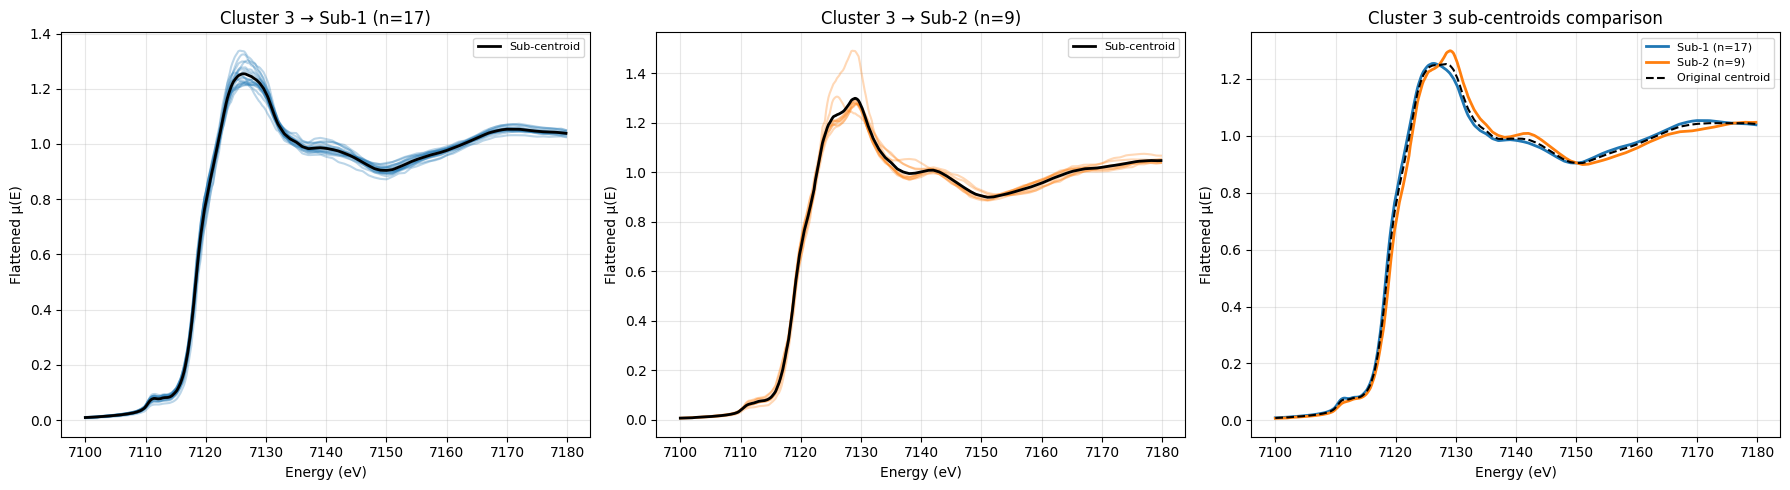


Cluster 4:
  Cluster 4, sub-k=2: silhouette=0.446
  Cluster 4, sub-k=3: silhouette=0.538
  Cluster 4, sub-k=4: silhouette=0.426
  Cluster 4, sub-k=5: silhouette=0.420


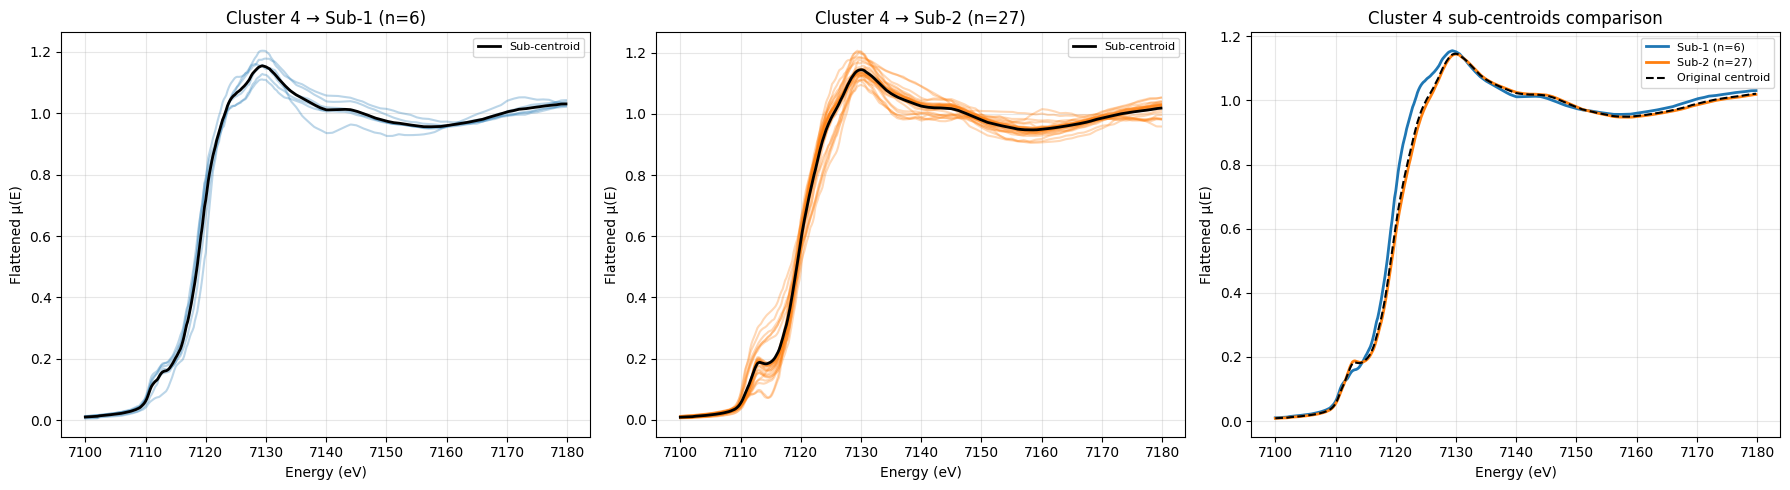

In [13]:
# Check clusters 3 and 4 (0-indexed: 2 and 3)
print("Cluster 3:")
sub3_labels, sub3_names = sub_cluster(scores, matrix, names, labels, 2, x_grid)

print("\nCluster 4:")
sub4_labels, sub4_names = sub_cluster(scores, matrix, names, labels, 3, x_grid)


Cluster 3 → Sub-1 (n=17)
Best fit (4 components, R=0.0240, χ²=0.000592):
  Biotite                        0.4394  (43.4%)
  Mackinawite                    0.0547  (5.4%)
  Pyrrhotite                     0.3362  (33.2%)
  Siderite-n                     0.1829  (18.0%)
  Sum                            1.0132

Cluster 3 → Sub-2 (n=9)
Best fit (4 components, R=0.0095, χ²=0.000099):
  Biotite                        0.5439  (53.2%)
  Mackinawite (aged)             0.3001  (29.4%)
  Siderite-n                     0.0851  (8.3%)
  Siderite-s                     0.0929  (9.1%)
  Sum                            1.0221


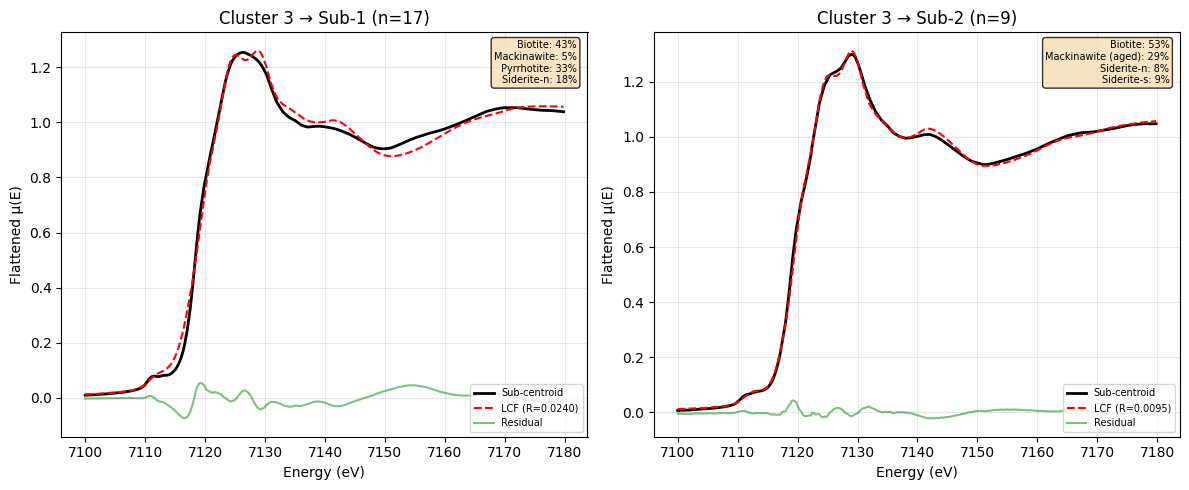

In [14]:
# Get cluster 3 sub-matrix (parent_cluster=2, 0-indexed)
mask3 = labels == 2
sub3_matrix = matrix[mask3]

sub3_lcf_results = lcf_sub_centroids(x_grid, sub3_matrix, sub3_labels, sub3_names, 
                  parent_cluster=2, reference_paths=REFERENCE_PATHS, max_refs=4)

---
## LCF of cluster centroids

Fit each cluster centroid as a linear combination of 1–4 mineral reference spectra
using non-negative least squares (NNLS). All combinations are tested to find the best fit.


Cluster 1 centroid
Best fit (4 components, R=0.0059, χ²=0.000035):
  Biotite                        0.0764  (7.5%)
  Hornblende                     0.4571  (44.6%)
  Mackinawite (aged)             0.2907  (28.3%)
  Vivianite                      0.2015  (19.6%)
  Sum                            1.0257

Cluster 2 centroid
Best fit (4 components, R=0.0061, χ²=0.000029):
  6L-Fhy                         0.4525  (44.5%)
  Augite                         0.2152  (21.2%)
  Biotite                        0.1275  (12.5%)
  Ferrosmectite                  0.2222  (21.8%)
  Sum                            1.0174

Cluster 3 centroid
Best fit (4 components, R=0.0177, χ²=0.000392):
  Biotite                        0.5044  (49.7%)
  Mackinawite                    0.2218  (21.8%)
  Pyrrhotite                     0.1112  (11.0%)
  Siderite-n                     0.1778  (17.5%)
  Sum                            1.0153

Cluster 4 centroid
Best fit (4 components, R=0.0129, χ²=0.000206):
  Biotite            

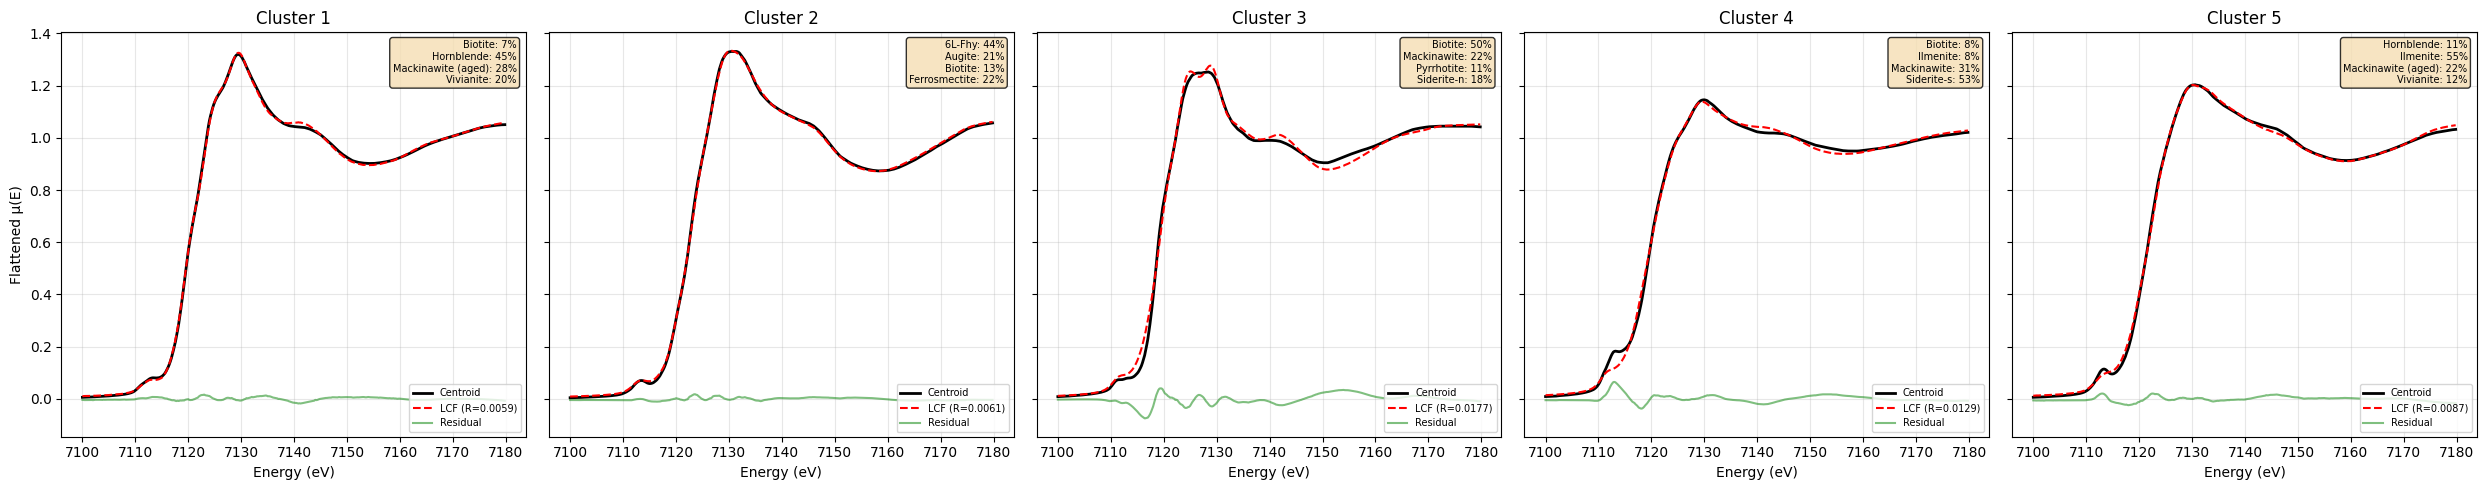

In [15]:
# LCF of cluster centroids against reference library
from itertools import combinations

def lcf_centroids(x_grid, centroids, reference_paths, max_refs=4, e_min=None, e_max=None):
    """
    Linear combination fitting of each cluster centroid against reference spectra.
    Tests all combinations of 1 to max_refs references and picks the best fit.
    """
    # Load and interpolate references
    refs = {}
    for ref_path in reference_paths:
        try:
            ref_dat = np.loadtxt(str(ref_path), delimiter=",", comments="#")
            ref_interp = np.interp(x_grid, ref_dat[:, 0], ref_dat[:, 1])
            refs[Path(ref_path).stem] = ref_interp
        except Exception as e:
            print(f"  Skipping {Path(ref_path).stem}: {e}")

    ref_names = list(refs.keys())
    ref_matrix = np.array([refs[n] for n in ref_names])

    # Optional energy mask
    if e_min is not None or e_max is not None:
        mask = np.ones(len(x_grid), dtype=bool)
        if e_min is not None:
            mask &= x_grid >= e_min
        if e_max is not None:
            mask &= x_grid <= e_max
    else:
        mask = np.ones(len(x_grid), dtype=bool)

    all_results = []

    for ci, centroid in enumerate(centroids):
        print(f"\n{'='*60}")
        print(f"Cluster {ci+1} centroid")
        print(f"{'='*60}")

        best_fit = {"r_factor": np.inf}

        # Try combinations of 1 to max_refs references
        for n_ref in range(1, max_refs + 1):
            for combo in combinations(range(len(ref_names)), n_ref):
                combo_names = [ref_names[i] for i in combo]
                A = ref_matrix[list(combo)][:, mask].T
                b = centroid[mask]

                # Non-negative least squares
                from scipy.optimize import nnls
                weights, rnorm = nnls(A, b)

                # Compute fit quality
                fitted = A @ weights
                residual = b - fitted
                r_factor = np.sum(np.abs(residual)) / np.sum(np.abs(b))
                chi_sq = np.sum(residual ** 2) / len(residual)
                weight_sum = np.sum(weights)

                if r_factor < best_fit["r_factor"]:
                    best_fit = {
                        "refs": combo_names,
                        "weights": weights,
                        "weight_sum": weight_sum,
                        "r_factor": r_factor,
                        "chi_sq": chi_sq,
                        "fitted": np.zeros_like(centroid),
                        "n_refs": n_ref,
                    }
                    best_fit["fitted"][mask] = fitted

        # Print best fit
        print(f"Best fit ({best_fit['n_refs']} components, R={best_fit['r_factor']:.4f}, "
              f"χ²={best_fit['chi_sq']:.6f}):")
        for name, w in zip(best_fit["refs"], best_fit["weights"]):
            pct = w / best_fit["weight_sum"] * 100 if best_fit["weight_sum"] > 0 else 0
            print(f"  {name:<30s} {w:.4f}  ({pct:.1f}%)")
        print(f"  {'Sum':<30s} {best_fit['weight_sum']:.4f}")

        best_fit["cluster"] = ci + 1
        all_results.append(best_fit)

    # Plot fits
    n_clusters = len(centroids)
    fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5), sharey=True)
    if n_clusters == 1:
        axes = [axes]

    for ci, (centroid, result) in enumerate(zip(centroids, all_results)):
        ax = axes[ci]
        ax.plot(x_grid, centroid, "k-", linewidth=2, label="Centroid")
        ax.plot(x_grid, result["fitted"], "r--", linewidth=1.5, label=f"LCF (R={result['r_factor']:.4f})")
        ax.plot(x_grid, centroid - result["fitted"], "g-", alpha=0.5, label="Residual")

        # Build legend with components
        legend_text = "\n".join(
            f"{n}: {w/result['weight_sum']*100:.0f}%"
            for n, w in zip(result["refs"], result["weights"])
        )
        ax.text(0.98, 0.98, legend_text, transform=ax.transAxes,
                fontsize=7, verticalalignment="top", horizontalalignment="right",
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

        ax.set_xlabel("Energy (eV)")
        ax.set_title(f"Cluster {ci+1}")
        ax.legend(fontsize=7, loc="lower right")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Flattened μ(E)")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "lcf_centroids.png", dpi=150, bbox_inches="tight")
    plt.show()

    return all_results

lcf_results = lcf_centroids(x_grid, centroids, REFERENCE_PATHS, max_refs=4)

## LCF of individual spectra

Fit every individual spectrum (1–3 reference components). This is computationally
intensive but provides per-spectrum phase assignments.

In [16]:
# LCF of individual spectra against reference library
    
def lcf_individual_spectra(x_grid, matrix, names, labels, reference_paths, 
                           max_refs=3, e_min=None, e_max=None):
    """
    Linear combination fitting of each individual spectrum against reference spectra.
    Returns a DataFrame with fit results for every spectrum.
    """
    from scipy.optimize import nnls
    from itertools import combinations

    # Load and interpolate references
    refs = {}
    for ref_path in reference_paths:
        try:
            ref_dat = np.loadtxt(str(ref_path), delimiter=",", comments="#")
            ref_interp = np.interp(x_grid, ref_dat[:, 0], ref_dat[:, 1])
            refs[Path(ref_path).stem] = ref_interp
        except Exception as e:
            print(f"  Skipping {Path(ref_path).stem}: {e}")

    ref_names = list(refs.keys())
    ref_matrix = np.array([refs[n] for n in ref_names])

    # Energy mask
    mask = np.ones(len(x_grid), dtype=bool)
    if e_min is not None:
        mask &= x_grid >= e_min
    if e_max is not None:
        mask &= x_grid <= e_max

    # Precompute all reference combinations
    all_combos = []
    for n_ref in range(1, max_refs + 1):
        for combo in combinations(range(len(ref_names)), n_ref):
            all_combos.append(combo)
    print(f"Testing {len(all_combos)} reference combinations per spectrum "
          f"({len(matrix)} spectra = {len(all_combos) * len(matrix):,} total fits)")

    # Fit each spectrum
    results = []
    for si in range(len(matrix)):
        spectrum = matrix[si]
        b = spectrum[mask]
        best = {"r_factor": np.inf}

        for combo in all_combos:
            A = ref_matrix[list(combo)][:, mask].T
            weights, _ = nnls(A, b)
            fitted = A @ weights
            residual = b - fitted
            r_factor = np.sum(np.abs(residual)) / np.sum(np.abs(b))

            if r_factor < best["r_factor"]:
                best = {
                    "refs": [ref_names[i] for i in combo],
                    "weights": weights,
                    "r_factor": r_factor,
                    "chi_sq": np.sum(residual ** 2) / len(residual),
                    "weight_sum": np.sum(weights),
                }

        # Build result row
        row = {
            "spectrum": names[si],
            "cluster": labels[si] + 1,
            "r_factor": best["r_factor"],
            "chi_sq": best["chi_sq"],
            "weight_sum": best["weight_sum"],
            "n_refs": len(best["refs"]),
        }
        for rn, w in zip(best["refs"], best["weights"]):
            row[rn] = w / best["weight_sum"] if best["weight_sum"] > 0 else 0
        results.append(row)

        if (si + 1) % 25 == 0 or si == len(matrix) - 1:
            print(f"  Fitted {si+1}/{len(matrix)} spectra")

    df = pd.DataFrame(results).fillna(0)

    # Sort reference columns by frequency of appearance
    ref_cols = [c for c in df.columns if c in ref_names]
    ref_cols_sorted = sorted(ref_cols, key=lambda c: (df[c] > 0).sum(), reverse=True)
    meta_cols = ["spectrum", "cluster", "r_factor", "chi_sq", "weight_sum", "n_refs"]
    df = df[meta_cols + ref_cols_sorted]

    # Print summary by cluster
    print(f"\n{'='*70}")
    print("SUMMARY: Average composition by cluster (normalized %)")
    print(f"{'='*70}")
    for ci in sorted(df["cluster"].unique()):
        cdf = df[df["cluster"] == ci]
        print(f"\nCluster {ci} (n={len(cdf)}, mean R={cdf['r_factor'].mean():.4f}):")
        for col in ref_cols_sorted:
            mean_pct = cdf[col].mean() * 100
            if mean_pct > 1:
                print(f"  {col:<30s} {mean_pct:5.1f}%")

    # Print poorly fit spectra
    poor_fits = df[df["r_factor"] > 0.05].sort_values("r_factor", ascending=False)
    if len(poor_fits) > 0:
        print(f"\n{'='*70}")
        print(f"POORLY FIT SPECTRA (R > 0.05): {len(poor_fits)} spectra")
        print(f"{'='*70}")
        for _, row in poor_fits.iterrows():
            print(f"  {row['spectrum']:<50s} R={row['r_factor']:.4f}  cluster={row['cluster']}")
    else:
        print(f"\nAll spectra fit with R < 0.05")

    # Save
    outpath = OUTPUT_DIR / "lcf_individual.csv"
    df.to_csv(outpath, index=False, float_format="%.4f")
    print(f"\nSaved: {outpath}")

    return df

lcf_df = lcf_individual_spectra(x_grid, matrix, names, labels, REFERENCE_PATHS, max_refs=3)

Testing 3682 reference combinations per spectrum (172 spectra = 633,304 total fits)
  Fitted 25/172 spectra
  Fitted 50/172 spectra
  Fitted 75/172 spectra
  Fitted 100/172 spectra
  Fitted 125/172 spectra
  Fitted 150/172 spectra
  Fitted 172/172 spectra

SUMMARY: Average composition by cluster (normalized %)

Cluster 1 (n=51, mean R=0.0136):
  Biotite                         19.0%
  Mackinawite (aged)              15.3%
  Hornblende                      20.5%
  Siderite-s                      10.4%
  Augite                          15.7%
  Vivianite                        6.0%
  Green Rust - Carbonate           4.4%
  Hematite                         1.1%
  2L-Fhy                           1.3%
  Pyrite                           1.3%

Cluster 2 (n=36, mean R=0.0113):
  Biotite                          4.0%
  Mackinawite (aged)               2.2%
  Hornblende                      19.4%
  Augite                          12.8%
  Vivianite                        1.1%
  6L-Fhy            